In [2]:
import pandas as pd
import tqdm
import json
import glob
import tempfile
import subprocess
import os
from pathlib import Path
from dataclasses import dataclass

from load_mutations import load_buggy_models
from src.functions import *
from src.model import *

@dataclass
class Mutation:
    program_name: str
    program_source_before: str
    diff: str
    program_source_after: str
    operators: list[str]
    job_id: str
    mutation_order: int
    execution_result: dict
    mutation_object: dict
    result_object: dict


def apply_mutation(program_source: str, diff: str) -> str:
    """
    Applies diff to program_source by creating a temporary file and applying the diff to it.
    """
    # Write program_source to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, mode="w") as temp_file:
        temp_file.write(program_source)
        temp_file_path = temp_file.name

    # Write diff to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, mode="w") as diff_file:
        diff_file.write(diff)
        diff_file_path = diff_file.name

    # Apply the diff to the temporary file
    subprocess.run(
        f"patch -F 3 {temp_file_path} {diff_file_path}",
        shell=True,
        capture_output=True,
        check=True,
    )

    # Read the modified source code
    with open(temp_file_path, "r") as modified_file:
        modified_source = modified_file.read()

    # Clean up the temporary files
    os.remove(temp_file_path)
    os.remove(diff_file_path)

    return modified_source


def parse_output(results_data: dict) -> dict:
    """
    Parses the stdout of the execution of the mutation. Looks for the flags:
    - "UNCOMPILABLE MODEL"
    - "MODEL IS NOT BUGGY"
    - "Accuracy: XX"
    """
    if results_data["output"] is None:
        return {"status": "UNKNOWN_FAILURE"}

    output = results_data["output"].split(
        "=================================== FAILURES ==================================="
    )[0]

    if any(
        error in output
        for error in [
            "SyntaxError",
            "TypeError",
            "AttributeError",
            "IndexError",
            "rasp.py:388: AssertionError",
            "shuffle_dyck.py:100: AssertionError",
            "shuffle_dyck.py:95: AssertionError",
            "shuffle_dyck2.py:100: AssertionError",
            "shuffle_dyck2.py:95: AssertionError",
        ]
    ):
        return {"status": "FAILED_MUTATION"}
    elif "timeout" in output:
        return {"status": "TIMEOUT"}
    elif "TypeError" in output:
        return {"status": "TYPE_ERROR"}
    elif "UNCOMPILABLE MODEL" in output:
        return {"status": "UNCOMPILABLE_MODEL"}
    elif "MODEL IS NOT BUGGY" in output:
        return {"status": "CORRECT_MODEL"}
    elif "Accuracy: " in output:
        return {
            "status": "BUGGY_MODEL",
            "accuracy": float(output.split("Accuracy: ")[1].split("\n")[0]),
        }
    else:
        raise ValueError(f"Unknown output: {results_data["output"]}")


def process_mutation(mutation_data: tuple[dict, dict], program_name: str) -> Mutation:
    """
    Builds the mutation data structure from the mutation_data object.
    """
    # Read the program source code
    program_source = Path(f"source/{program_name}.py").read_text()
    # Apply the mutation to the program source code
    diff = mutation_data[1]["diff"]
    program_source_after = None
    if diff is not None:
        program_source_after = apply_mutation(program_source, diff)

    # Parse the output
    execution_result = parse_output(mutation_data[1])

    return Mutation(
        program_name=program_name,
        program_source_before=program_source,
        diff=diff,
        program_source_after=program_source_after,
        operators=[mutation["operator_name"] for mutation in mutation_data[0]["mutations"]],
        job_id=mutation_data[0]["job_id"],
        mutation_order=len(mutation_data[0]["mutations"]),
        execution_result=execution_result,
        mutation_object=mutation_data[0],
        result_object=mutation_data[1],
    )


# Find all tracr_*.jsonl files in the results directory and its subdirectories
results_dir = Path("results")
mutation_files = glob.glob(str(results_dir / "**/tracr_*.jsonl"), recursive=True)

# Initialize an empty list to store all mutations
all_mutations = []

# Process each mutation file
for file_path in tqdm.tqdm(mutation_files):
    # Extract program name from the file path
    program_name = Path(file_path).parent.name

    # Read and process each line in the JSONL file
    with open(file_path, "r") as f:
        for line in tqdm.tqdm(f):
            mutation_data = json.loads(line)
            # mutation_data has two elements, the first is the mutation and the second is the execution result
            # we aggregate them
            all_mutations.append(process_mutation(mutation_data, program_name))

# Convert to DataFrame
df = pd.DataFrame(all_mutations)

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample of the data:")
display(df.head())

# Save the DataFrame to a JSON file
df.to_json("results/aggregated_mutations.json", index=False, indent=4)

11it [00:00, 259.00it/s]0:00<?, ?it/s]
33it [00:00, 287.20it/s]
37it [00:00, 276.59it/s]0:00<00:02, 12.23it/s]
14it [00:00, 276.66it/s]
0it [00:00, ?it/s]/30 [00:00<00:02, 11.25it/s]
107it [00:00, 274.97it/s]
200it [00:00, 288.98it/s]:00<00:03,  7.25it/s]
200it [00:00, 255.44it/s]:01<00:06,  3.64it/s]
200it [00:00, 275.41it/s]:02<00:08,  2.46it/s]
200it [00:00, 246.30it/s]:02<00:10,  2.02it/s]
53it [00:00, 189.46it/s]00:03<00:11,  1.71it/s]
200it [00:00, 249.45it/s]0:04<00:09,  2.01it/s]
200it [00:00, 247.41it/s]0:04<00:10,  1.70it/s]
200it [00:00, 252.80it/s]0:05<00:11,  1.53it/s]
200it [00:00, 315.63it/s]0:06<00:11,  1.44it/s]
200it [00:00, 272.33it/s]0:07<00:10,  1.48it/s]
200it [00:00, 266.56it/s]0:07<00:09,  1.44it/s]
200it [00:00, 218.30it/s]0:08<00:09,  1.40it/s]
200it [00:00, 218.69it/s]0:09<00:09,  1.29it/s]
200it [00:01, 190.06it/s]0:10<00:08,  1.22it/s]
200it [00:00, 224.72it/s]0:11<00:08,  1.13it/s]
200it [00:00, 258.09it/s]0:12<00:07,  1.13it/s]
200it [00:00, 232.76it/s]0:

Dataset shape: (4727, 10)

Columns: ['program_name', 'program_source_before', 'diff', 'program_source_after', 'operators', 'job_id', 'mutation_order', 'execution_result', 'mutation_object', 'result_object']

Sample of the data:


,program_name,program_source_before,diff,program_source_after,operators,job_id,mutation_order,execution_result,mutation_object,result_object
0,hist,from tracr.rasp import rasp\n\n\ndef make_hist...,--- mutation diff ---\n--- asource/hist.py\n++...,from tracr.rasp import rasp\n\n\ndef make_hist...,[operators/replace-rasp-comparison],2a722d5d5449441fad93f98c73c633a2,1,"{'status': 'BUGGY_MODEL', 'accuracy': 0.0}","{'job_id': '2a722d5d5449441fad93f98c73c633a2',...","{'worker_outcome': 'normal', 'output': '======..."
1,hist,from tracr.rasp import rasp\n\n\ndef make_hist...,--- mutation diff ---\n--- asource/hist.py\n++...,from tracr.rasp import rasp\n\n\ndef make_hist...,[operators/replace-rasp-comparison],ee8c6dd459324fa4a1269e1b30635bd5,1,"{'status': 'BUGGY_MODEL', 'accuracy': 0.0}","{'job_id': 'ee8c6dd459324fa4a1269e1b30635bd5',...","{'worker_outcome': 'normal', 'output': '======..."
2,hist,from tracr.rasp import rasp\n\n\ndef make_hist...,--- mutation diff ---\n--- asource/hist.py\n++...,from tracr.rasp import rasp\n\n\ndef make_hist...,[operators/replace-rasp-comparison],ca28aa28e26c4e67b9987911b50b8ae4,1,"{'status': 'BUGGY_MODEL', 'accuracy': 0.0}","{'job_id': 'ca28aa28e26c4e67b9987911b50b8ae4',...","{'worker_outcome': 'normal', 'output': '======..."
3,hist,from tracr.rasp import rasp\n\n\ndef make_hist...,--- mutation diff ---\n--- asource/hist.py\n++...,from tracr.rasp import rasp\n\n\ndef make_hist...,[operators/replace-rasp-comparison],cf0cecafd2aa49a49bba26146d55b1ff,1,"{'status': 'BUGGY_MODEL', 'accuracy': 0.0}","{'job_id': 'cf0cecafd2aa49a49bba26146d55b1ff',...","{'worker_outcome': 'normal', 'output': '======..."
4,hist,from tracr.rasp import rasp\n\n\ndef make_hist...,--- mutation diff ---\n--- asource/hist.py\n++...,from tracr.rasp import rasp\n\n\ndef make_hist...,[operators/replace-rasp-comparison],915a38d1da254c769c958982c210c27b,1,"{'status': 'BUGGY_MODEL', 'accuracy': 0.0}","{'job_id': '915a38d1da254c769c958982c210c27b',...","{'worker_outcome': 'normal', 'output': '======..."


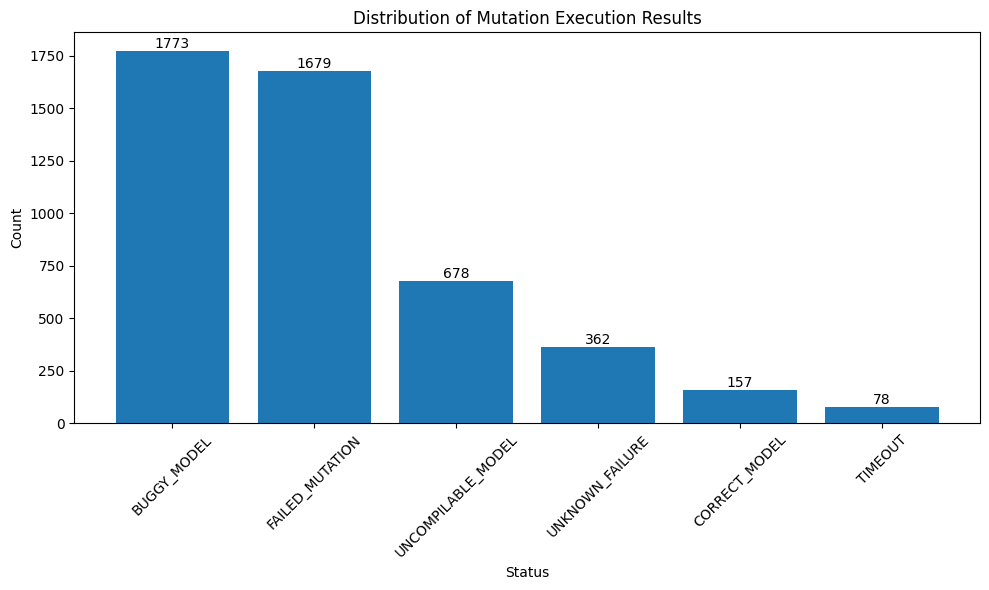

In [3]:
# Create a bar plot of execution results
import matplotlib.pyplot as plt

# Count the different status types
status_counts = df["execution_result"].apply(lambda x: x["status"]).value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(status_counts.index, status_counts.values)

# Customize the plot
plt.title("Distribution of Mutation Execution Results")
plt.xlabel("Status")
plt.ylabel("Count")
plt.xticks(rotation=45)

# Add value labels on top of each bar
for i, v in enumerate(status_counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

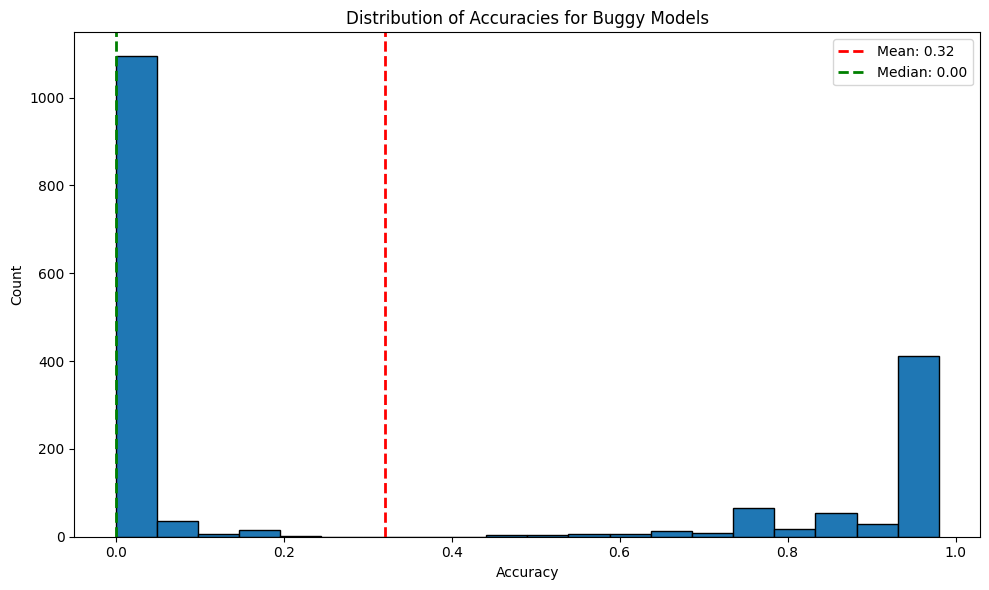

Number of buggy models: 1773
Mean accuracy: 0.32
Median accuracy: 0.00
Min accuracy: 0.00
Max accuracy: 0.98


In [4]:
# Filter for only BUGGY_MODEL results and extract accuracies
buggy_models = df[df["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")]
accuracies = buggy_models["execution_result"].apply(lambda x: x["accuracy"])

# Create histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=20, edgecolor="black")

# Customize the plot
plt.title("Distribution of Accuracies for Buggy Models")
plt.xlabel("Accuracy")
plt.ylabel("Count")

# Add summary statistics
plt.axvline(
    accuracies.mean(),
    color="red",
    linestyle="dashed",
    linewidth=2,
    label=f"Mean: {accuracies.mean():.2f}",
)
plt.axvline(
    accuracies.median(),
    color="green",
    linestyle="dashed",
    linewidth=2,
    label=f"Median: {accuracies.median():.2f}",
)

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of buggy models: {len(accuracies)}")
print(f"Mean accuracy: {accuracies.mean():.2f}")
print(f"Median accuracy: {accuracies.median():.2f}")
print(f"Min accuracy: {accuracies.min():.2f}")
print(f"Max accuracy: {accuracies.max():.2f}")

In [5]:
# Create a summary table by program
summary = []
for program in df["program_name"].unique():
    program_data = df[df["program_name"] == program]
    total = len(program_data)

    # Count different status types
    status_counts = (
        program_data["execution_result"].apply(lambda x: x["status"]).value_counts()
    )

    # Calculate mean accuracy for buggy models
    buggy_models = program_data[
        program_data["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")
    ]
    mean_accuracy = (
        buggy_models["execution_result"].apply(lambda x: x["accuracy"]).mean()
    )

    summary.append(
        {
            "Program": program,
            "Total Mutations": total,
            "Unknown Failures": f"{status_counts.get('UNKNOWN_FAILURE', 0)} ({status_counts.get('UNKNOWN_FAILURE', 0)/total*100:.1f}%)",
            "Failed Mutations": f"{status_counts.get('FAILED_MUTATION', 0)} ({status_counts.get('FAILED_MUTATION', 0)/total*100:.1f}%)",
            "Uncompilable": f"{status_counts.get('UNCOMPILABLE_MODEL', 0)} ({status_counts.get('UNCOMPILABLE_MODEL', 0)/total*100:.1f}%)",
            "Correct Models": f"{status_counts.get('CORRECT_MODEL', 0)} ({status_counts.get('CORRECT_MODEL', 0)/total*100:.1f}%)",
            "Buggy Models": f"{status_counts.get('BUGGY_MODEL', 0)} ({status_counts.get('BUGGY_MODEL', 0)/total*100:.1f}%)",
            "Timeouts": f"{status_counts.get('TIMEOUT', 0)} ({status_counts.get('TIMEOUT', 0)/total*100:.1f}%)",
            "Mean Accuracy (Buggy)": (
                f"{mean_accuracy:.2f}" if not pd.isna(mean_accuracy) else "N/A"
            ),
        }
    )

summary_df = pd.DataFrame(summary)
summary_df = summary_df.sort_values("Total Mutations", ascending=False)

# Calculate totals
total_mutations = df.shape[0]
total_status_counts = df["execution_result"].apply(lambda x: x["status"]).value_counts()
total_buggy = df[df["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")]
total_mean_accuracy = (
    total_buggy["execution_result"].apply(lambda x: x["accuracy"]).mean()
)

# Add total row
total_row = pd.DataFrame(
    [
        {
            "Program": "TOTAL",
            "Total Mutations": total_mutations,
            "Unknown Failures": f"{total_status_counts.get('UNKNOWN_FAILURE', 0)} ({total_status_counts.get('UNKNOWN_FAILURE', 0)/total_mutations*100:.1f}%)",
            "Failed Mutations": f"{total_status_counts.get('FAILED_MUTATION', 0)} ({total_status_counts.get('FAILED_MUTATION', 0)/total_mutations*100:.1f}%)",
            "Uncompilable": f"{total_status_counts.get('UNCOMPILABLE_MODEL', 0)} ({total_status_counts.get('UNCOMPILABLE_MODEL', 0)/total_mutations*100:.1f}%)",
            "Correct Models": f"{total_status_counts.get('CORRECT_MODEL', 0)} ({total_status_counts.get('CORRECT_MODEL', 0)/total_mutations*100:.1f}%)",
            "Buggy Models": f"{total_status_counts.get('BUGGY_MODEL', 0)} ({total_status_counts.get('BUGGY_MODEL', 0)/total_mutations*100:.1f}%)",
            "Timeouts": f"{total_status_counts.get('TIMEOUT', 0)} ({total_status_counts.get('TIMEOUT', 0)/total_mutations*100:.1f}%)",
            "Mean Accuracy (Buggy)": (
                f"{total_mean_accuracy:.2f}"
                if not pd.isna(total_mean_accuracy)
                else "N/A"
            ),
        }
    ]
)

# Combine summary and total
summary_df = pd.concat([summary_df, total_row])

# Display the table with better formatting
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
display(summary_df)

,Program,Total Mutations,Unknown Failures,Failed Mutations,Uncompilable,Correct Models,Buggy Models,Timeouts,Mean Accuracy (Buggy)
4,shuffle_dyck2,1000,15 (1.5%),412 (41.2%),166 (16.6%),33 (3.3%),310 (31.0%),64 (6.4%),0.91
3,shuffle_dyck,1000,24 (2.4%),385 (38.5%),149 (14.9%),97 (9.7%),345 (34.5%),0 (0.0%),0.80
1,most_freq,907,86 (9.5%),301 (33.2%),148 (16.3%),13 (1.4%),346 (38.1%),13 (1.4%),0.02
5,sort,872,85 (9.7%),289 (33.1%),162 (18.6%),9 (1.0%),326 (37.4%),1 (0.1%),0.01
2,reverse,853,152 (17.8%),292 (34.2%),53 (6.2%),4 (0.5%),352 (41.3%),0 (0.0%),0.00
0,hist,95,0 (0.0%),0 (0.0%),0 (0.0%),1 (1.1%),94 (98.9%),0 (0.0%),0.00
0,TOTAL,4727,362 (7.7%),1679 (35.5%),678 (14.3%),157 (3.3%),1773 (37.5%),78 (1.7%),0.32


In [6]:
# Filter df for buggy_models
buggy_models = df[df["execution_result"].apply(lambda x: x["status"] == "BUGGY_MODEL")]

# Get one buggy model for each program
for program in buggy_models["program_name"].unique():
    program_data = buggy_models[buggy_models["program_name"] == program]
    print(program_data.iloc[0]["program_name"], program_data.iloc[0]["job_id"])

hist 2a722d5d5449441fad93f98c73c633a2
most_freq d6de3b3af9fe403faeac2b7b7f0b5f85
reverse 2b6f62a96b1d411a81185c47fcf323ab
shuffle_dyck 28357cf95fbd4389a311073d185756b8
shuffle_dyck2 95b38e6e8ede42268ff62e85f987dfa7
sort 4795828b71974ec8829297c301a19dfe


In [6]:
import tqdm

def compute_diff(row: dict) -> dict:
    """
    Computes the diff between the original and mutated source code.
    """
    # Only apply to buggy models
    if row["execution_result"].get("status") != "BUGGY_MODEL":
        return None

    # Get the job_id
    job_id = row["job_id"]

    # Load the buggy model
    buggy_models = load_buggy_models(max_length=10, program_name=row["program_name"], job_id=job_id)
    buggy_model = list(buggy_models.values())[0]

    # Load the original model
    original_model = generateModel(row["program_name"], maxLength=10)

    return original_model.diff(buggy_model).to_dict()

# Add diff to each entry
tqdm.tqdm.pandas()
df["diff"] = df.progress_apply(compute_diff, axis=1)

100%|██████████| 700/700 [4:47:04<00:00, 24.61s/it]     


In [7]:
# Save the DataFrame to a JSON file
df.to_json("results/aggregated_mutations_with_diff.json", index=False, indent=4)